# Tuning the model
I tried to calibrate the model by tuning the precipitation scaling factor (`prcp_scaling_factor`) as well as the creep parameter (`inversion_glen_a`  & `glen_a`) in order to reproduce the observed length changes. Both parameters are used during the calibration (inversion) phase as well as during the model run.

My first idea was to use the same (changed) parameters for the calibration and the model run. Even though this approach is better from a physical standpoint, the result contain certain artefacts which complicate the (qualitative) analysis. Hence, the second cross correlation is performed changing only the model parameters while keeping the calibration parameters constant (at default vaules).

1. **Minimal working example:** Piecing together a full model run from start to finish, where it is possible to choose the values for the precipitation scaling parameter and the creep parameter.
2. **Analyse results:** The script `../code/` runs the model for a set of different combinations of precipitation scaling parameter and the creep parameter and stores the modeled glacier length in a file. Here I compute the correlation between model output and reference values

The findings are written up in `../text/`.

## Minimal working example

### Import

In [1]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities, rmsd, rmsd_anomaly
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

### Initialize

In [2]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define big border
cfg.PARAMS['border'] = 250

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-04-16 14:21:40: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


### Preprocessing

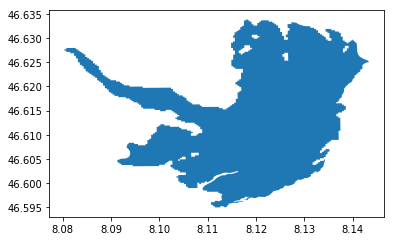

In [3]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [4]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [5]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

#### GIS

In [6]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-04-16 14:21:45: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-04-16 14:21:46: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (592, 583)
  Grid (dx, dy): (52.0, -52.0)

#### Centerlines

In [7]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-04-16 14:21:47: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-04-16 14:21:48: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-04-16 14:21:48: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-04-16 14:21:53: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-04-16 14:21:55: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-04-16 14:21:57: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-04-16 14:21:57: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-04-16 14:21:58: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


#### Climate and mass balance parameters

In [8]:
cfg.PARAMS
# process the HistAlp climate file
climate.process_histalp_data(gdir)
# here I'll change the precipitation scaling parameter
cfg.PARAMS['prcp_scaling_factor'] = 1
ref_df = pd.read_csv('/Users/oberrauch/work/grindelwald/ref_tstars/ref_tstars_prcp_1_00.csv', index_col=0)
climate.local_t_star(gdir, ref_df=ref_df)
climate.mu_star_calibration(gdir)

2019-04-16 14:21:58: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-04-16 14:22:01: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-16 14:22:01: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1907
2019-04-16 14:22:01: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


#### Mass balance

In [9]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

#### Inversion

In [10]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
factor = 0.1
inv_glen_a = cfg.PARAMS['inversion_glen_a'] * factor
inversion.mass_conservation_inversion(gdir, glen_a=inv_glen_a)
inversion.filter_inversion_output(gdir)

2019-04-16 14:22:05: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-16 14:22:05: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-16 14:22:05: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-04-16 14:22:05: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp
2019-04-16 14:22:05: oggm.core.gis: (RGI60-11.01270) interpolation_masks
/Users/oberrauch/oggm-fork/oggm/core/gis.py:908: RuntimeWarning: invalid value encountered in sqrt
  slope = np.arctan(np.sqrt(sy**2 + sx**2))


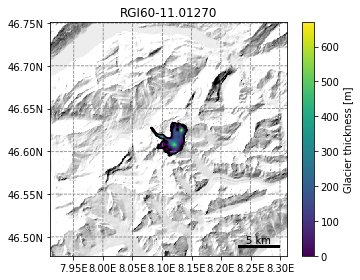

In [11]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

#### Dynamic model

In [12]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-16 14:22:08: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


### Model

In [13]:
# read needed file
ci =  gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

In [14]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, glen_a=cfg.PARAMS['glen_a']*factor,
                                y0=ci['baseline_hydro_yr_0'])

In [15]:
# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

### Results

In [16]:
# get modeled length changes as DataFrame
length_mod = diag_ds.length_m.to_dataframe()[['hydro_year','length_m']]
length_mod = length_mod.reindex(index=length_mod.hydro_year)
length_mod.drop('hydro_year', axis=1, inplace=True)
length_mod.columns = ['model']

# get reference length
from oggm.grindel.utils import get_leclercq_length
length_ref = get_leclercq_length('11.01270')

In [17]:
# combine both records
length_df = pd.concat([length_ref, length_mod], axis=1)
# offset reference
length_df.ref += length_df.dropna().diff(axis=1).mean()['model']

# select 'control' data period
control = length_df.loc[1894:]

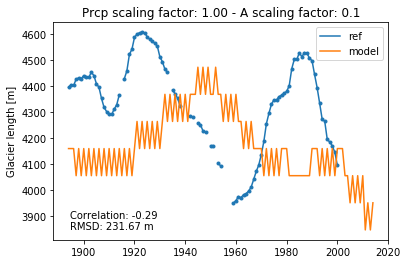

In [18]:
# plot lenght changes
ax = control.plot()
# add dot marker to observes length changes
ax.get_lines()[0].set_marker('.')

# add correlation and rmsd
corr = control.corr().iloc[0,1]
rmsd = rmsd_anomaly(control.ref, control.model)
ax.text(0.05, 0.1, 'Correlation: {:.2f}'.format(corr), transform=ax.transAxes)
ax.text(0.05, 0.05, 'RMSD: {:.2f} m'.format(rmsd), transform=ax.transAxes)
# labels, title, ...
ax.set_ylabel('Glacier length [m]')
ax.set_title('Prcp scaling factor: {:.2f} - A scaling factor: {:.1f}'.format(cfg.PARAMS['prcp_scaling_factor'], factor))

# save to file
fn = ax.get_title().lower()
fn = fn.replace(' - ', '_').replace(' ', '_').replace('.', '_').replace(':', '') + '.pdf'
fn = os.path.join('/Users/oberrauch/work/grindelwald/figures/glen_a/', fn)
plt.savefig(fn)

## 2a. Look at the results of the cross correlation
This cross correlation was performed using the `A param` and the `prcp_scaling_factor`, during the calibration phase and the model run.

In [7]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# define path
folder = '/Users/oberrauch/work/grindelwald/data/length_corr/'
filename = 'length_corr_prcp_fac_{:.2f}.csv'

# define range of prcp factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)
# define scaling factors for the creep parameters
factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                          np.linspace(1, 20, 20)))

# define empty containers
correlation = pd.DataFrame(index=factors, columns=prcp_facs)
rmsd = pd.DataFrame(index=factors, columns=prcp_facs)
amp_diff = pd.DataFrame(index=factors, columns=prcp_facs)
xcorr = pd.DataFrame(index=factors, columns=prcp_facs)
xcorr_shift = pd.DataFrame(index=factors, columns=prcp_facs)

# iterate over all precipitation factors
for prcp_fac in prcp_facs:
    fn = os.path.join(folder, filename.format(prcp_fac))
    df = pd.read_csv(fn, index_col=0)
    correlation.loc[:, prcp_fac] = df.correlation
    rmsd.loc[:, prcp_fac] = df.rmsd
    amp_diff.loc[:, prcp_fac] = df.amp_diff
    xcorr.loc[:, prcp_fac] = df.xcorr
    xcorr_shift.loc[:, prcp_fac] = df.xcorr_shift

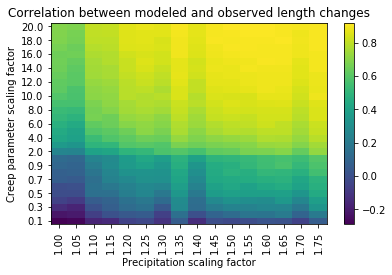

In [10]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(correlation.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Correlation between modeled and observed length changes')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/correlation.pdf')

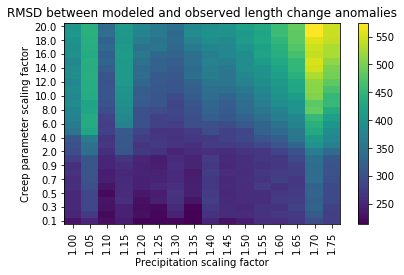

In [11]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(rmsd.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('RMSD between modeled and observed length change anomalies')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/rmsd.pdf')

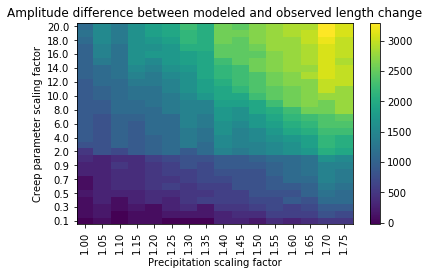

In [12]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(amp_diff.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Amplitude difference between modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/amp_diff.pdf')

In [13]:
# define threshold of amplitude difference in meters
threshold = 250
# get parameter combinations
amp_diff[amp_diff <= threshold].dropna(how='all')

,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75
0.1,-31.0,73.0,-31.0,73.0,73.0,-31.0,-31.0,-31.0,NaN,NaN,177.0,NaN,NaN,NaN,NaN,NaN
0.2,73.0,177.0,-31.0,73.0,73.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,73.0,177.0,73.0,177.0,73.0,NaN,NaN,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,73.0,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


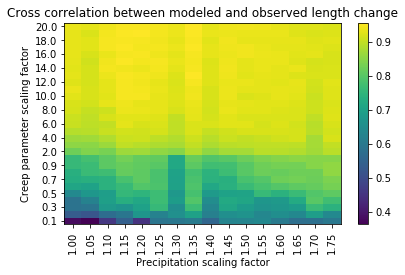

In [14]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(xcorr.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Cross correlation between modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/xcorr.pdf')

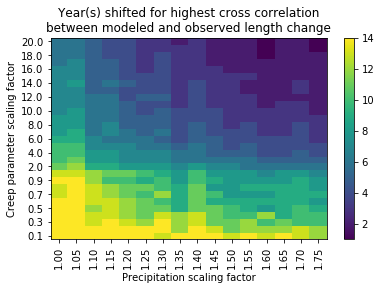

In [15]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(xcorr_shift.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Year(s) shifted for highest cross correlation\nbetween modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/xcorr_shift.pdf')

## 2b. Cross correlation, without mass balance calibration
This cross correlation was performed using the `A param` and the `prcp_scaling_factor`, without running the mass balance calbration.

In [16]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# define precipation scaling factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)

In [18]:
# define path
folder = '/Users/oberrauch/work/grindelwald/data/length_corr_no_mb_calib/'
filename = 'length_corr_prcp_fac_{:.2f}.csv'

# define range of prcp factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)
# define scaling factors for the creep parameters
factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                          np.linspace(1, 20, 20)))

# define empty containers
correlation = pd.DataFrame(index=factors, columns=prcp_facs)
rmsd = pd.DataFrame(index=factors, columns=prcp_facs)
amp_diff = pd.DataFrame(index=factors, columns=prcp_facs)

# iterate over all precipitation factors
for prcp_fac in prcp_facs:
    fn = os.path.join(folder, filename.format(prcp_fac))
    df = pd.read_csv(fn, index_col=0)
    correlation.loc[:, prcp_fac] = df.correlation
    rmsd.loc[:, prcp_fac] = df.rmsd
    amp_diff.loc[:, prcp_fac] = df.amp_diff

In [19]:
# plot countour lines [Y/N]
contour = False

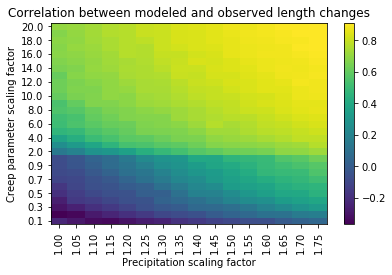

In [20]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(correlation.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Correlation between modeled and observed length changes')
# add contour lines
if contour:
    cs = ax.contour(correlation.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.2f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/correlation.pdf')

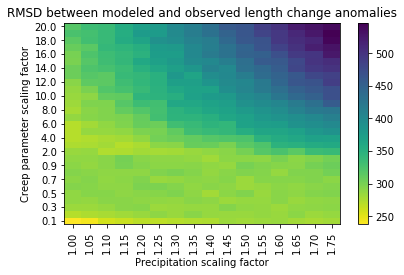

In [21]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(rmsd.values.astype(float), cmap='viridis_r')
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('RMSD between modeled and observed length change anomalies')
# add contour lines
if contour:
    cs = ax.contour(rmsd.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.0f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/rmsd.pdf')

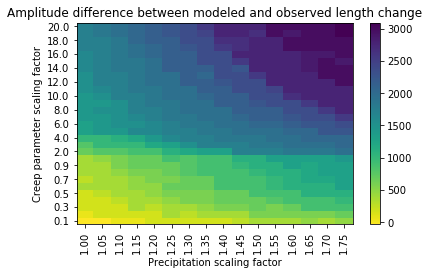

In [22]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(amp_diff.values.astype(float), cmap='viridis_r')
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Amplitude difference between modeled and observed length change')
# add contour lines
if contour:
    cs = ax.contour(amp_diff.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.0f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/amp_diff.pdf')

In [23]:
# define threshold of amplitude difference in meters
threshold = 250
# get parameter combinations
amp_diff[amp_diff <= threshold].dropna(how='all')

,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75
0.1,-31.0,-31.0,73.0,73.0,177.0,177.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,73.0,177.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
